In [13]:
import ctypes
import timeit

from tqdm import tqdm
import numpy as np
from scipy import integrate, LowLevelCallable
import numba as nb
from numba import types
import matplotlib.pyplot as plt

## Using quad

In [14]:
##################################################
# creating some sample data and parameters
M, sigma, q = np.loadtxt("/home/carlos/Desktop/Integral_tests/Input.txt", unpack=True, dtype=np.float64)


xbin  = 1e-5
ybin  = -1e-5

lim1 = 0
lim2 = 1

def function_using_arrays(tau, y, x, array1, array2, array3):
    x_til   = x/array2
    y_til   = y/array2
    eta     = np.sqrt(1.0 - array3**2)
    eta_sq  = 1 - array3**2
    
    aux     = (array1/array2) * (x_til/(np.sqrt(1 - eta_sq*(tau)**2)))
    exp_arg = (tau**2/2) * (x_til**2 + y_til**2/(1-eta_sq*(tau)**2))
    exp     = np.exp(-exp_arg)
    
    return tau * np.sum(aux*exp)


In [15]:
##################################################
# JIT INTEGRAND
function_using_arrays_nb = nb.njit(function_using_arrays)

def do_integrate_w_arrays_jit(ybin, xbin, array1, array2, array3, lolim=0, hilim=1):
    return integrate.quad(function_using_arrays_nb, lolim, hilim, (ybin, xbin, array1, array2, array3))

def process_jit_integrand_quad():
    do_integrate_w_arrays_jit(ybin, xbin, M, sigma, q, lolim=lim1, hilim=lim2)

In [16]:
%timeit process_jit_integrand_quad()

1.17 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
process_jit_integrand()

(6339769078492232.0, 5683.3720417022705)

## Using quadva

In [200]:
from jampy.quadva import quadva

def function_using_arrays_quadva(tau1, y, x, array1, array2, array3):
    
    tau = np.reshape(tau1.copy(), (tau1.size,1))
    x_til   = x/array2
    y_til   = y/array2
    eta     = np.sqrt(1.0 - array3**2)
    eta_sq  = 1 - array3**2
    
    aux     = (array1/array2) * (x_til/(np.sqrt(1 - eta_sq*(tau)**2)))
    exp_arg = (tau**2/2) * (x_til**2 + y_til**2/(1-eta_sq*(tau)**2))
    exp     = np.exp(-exp_arg)
    
    arr = aux*exp    
    
    return tau1 * np.sum(arr, 1)



In [18]:
##################################################
# JIT INTEGRAND
function_using_arrays_quadva_nb = nb.njit(function_using_arrays_quadva)

def do_integrate_quadva(ybin, xbin, array1, array2, array3, lolim=0, hilim=1):
    return quadva(function_using_arrays_quadva_nb, [lolim, hilim], args=(ybin, xbin, array1, array2, array3))

def process_jit_integrand_quadva():
    do_integrate_quadva(ybin, xbin, M, sigma, q, lolim=lim1, hilim=lim2)

In [19]:
%timeit process_jit_integrand_quadva()

898 µs ± 143 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
process_jit_integrand_quadva()

(6339769078491577.0, 53116633.01464843, 0)

### Testing velocity

In [20]:
repetitions = range(200)

In [21]:
jit_integrand_delays_quad = [timeit.timeit(stmt=process_jit_integrand_quad, number=repetition) for repetition in tqdm(repetitions)]

100%|██████████| 200/200 [00:23<00:00,  8.42it/s]


In [22]:
jit_integrand_delays_quadva = [timeit.timeit(stmt=process_jit_integrand_quadva, number=repetition) for repetition in tqdm(repetitions)]

100%|██████████| 200/200 [00:17<00:00, 11.59it/s]


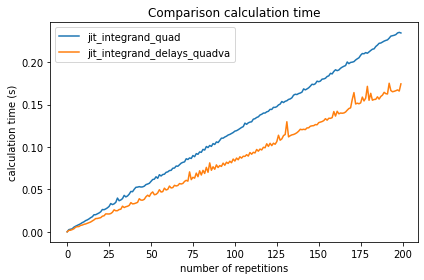

In [23]:
fig, ax = plt.subplots()
ax.plot(repetitions, jit_integrand_delays_quad, label="jit_integrand_quad")
ax.plot(repetitions, jit_integrand_delays_quadva, label="jit_integrand_delays_quadva")
ax.set_xlabel('number of repetitions')
ax.set_ylabel('calculation time (s)')
ax.set_title("Comparison calculation time")
plt.tight_layout()
plt.legend()

## LOWLEV CALLABLE quad

In [41]:
##################################################
# LOWLEV CALLABLE

def create_jit_integrand_function_quad(integrand_function, args_dtype):
    jitted_function = nb.njit(integrand_function)

    @nb.cfunc(types.float64(types.float64,types.CPointer(args_dtype)))
    def wrapped(tau,user_data_p):
        #Array of structs
        user_data = nb.carray(user_data_p, 1)

        #Extract the data
        y=user_data[0].ybin
        x=user_data[0].xbin
        array1=user_data[0].M
        array2=user_data[0].sigma
        array3=user_data[0].q

        return jitted_function(tau, y, x, array1, array2, array3)
    return wrapped


def do_integrate_w_arrays_lowlev_quad(func,args,lolim=0, hilim=1):
    integrand_func=LowLevelCallable(func.ctypes,user_data=args.ctypes.data_as(ctypes.c_void_p))
    return integrate.quad(integrand_func, lolim, hilim)


def process_lowlev_callable_quad():
    do_integrate_w_arrays_lowlev_quad(func_quad, np.array((ybin, xbin, M, sigma, q), dtype=args_dtype), lolim=0, hilim=1)


In [42]:
args_dtype = types.Record.make_c_struct([
            ('ybin', types.float64),
            ('xbin', types.float64),
            ('M', types.NestedArray(dtype=types.float64, shape=M.shape)),
            ('sigma', types.NestedArray(dtype=types.float64, shape=sigma.shape)),
            ('q', types.NestedArray(dtype=types.float64, shape=q.shape)),])

func_quad = create_jit_integrand_function_quad(function_using_arrays, args_dtype)


In [43]:
%timeit process_lowlev_callable_quad()

967 µs ± 3.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
process_lowlev_callable()

(6339769078492232.0, 5683.3720417022705)

In [44]:
lowlev_callable_delays_quad = [timeit.timeit(stmt=process_lowlev_callable_quad, number=repetition) for repetition in tqdm(repetitions)]

100%|██████████| 200/200 [00:20<00:00,  9.91it/s]


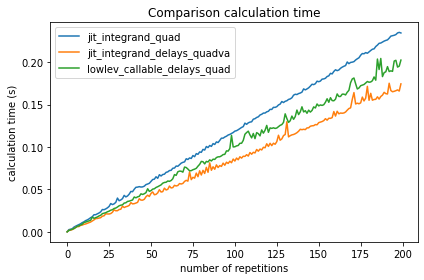

In [45]:
fig, ax = plt.subplots()
ax.plot(repetitions, jit_integrand_delays_quad, label="jit_integrand_quad")
ax.plot(repetitions, jit_integrand_delays_quadva, label="jit_integrand_delays_quadva")
ax.plot(repetitions, lowlev_callable_delays_quad, label="lowlev_callable_delays_quad")
ax.set_xlabel('number of repetitions')
ax.set_ylabel('calculation time (s)')
ax.set_title("Comparison calculation time")
plt.tight_layout()
plt.legend()